In [1]:
# Construct a TDSCatalog instance pointing to the gfs dataset
from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml')
print(list(best_gfs.datasets))

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Half Degree Forecast Time Series', 'Latest Collection for GFS Half Degree Forecast']


In [2]:
# Pull out the dataset you want to use and look at the access URLs
best_ds = list(best_gfs.datasets.values())[1]
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p5deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg/Best'}

In [3]:
# Create NCSS object to access the NetcdfSubset
from siphon.ncss import NCSS
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

In [4]:
from datetime import datetime
# Create lat/lon box for location you want to get data for
query = ncss.query()
query.lonlat_box(north=50, south=30, east=-80, west=-115).time(datetime.utcnow())
query.accept('netcdf4')

# Request data for MSLP
query.variables('MSLP_Eta_model_reduction_msl')
data = ncss.get_data(query)

# Pull out the variables you want to use
time_var = data.variables['time']
lat_var = data.variables['lat']
lon_var = data.variables['lon']
mslp_var = data.variables['MSLP_Eta_model_reduction_msl']

In [5]:
# Request data for 850-hPa winds
query.var=set()
query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.vertical_level(85000)
data = ncss.get_data(query)
u_wind_var850 = data.variables['u-component_of_wind_isobaric']
v_wind_var850 = data.variables['v-component_of_wind_isobaric']

In [6]:
# Request data for 500-hPa winds
query.var=set()
query.variables('u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.vertical_level(50000)
data = ncss.get_data(query)
u_wind_var500 = data.variables['u-component_of_wind_isobaric']
v_wind_var500 = data.variables['v-component_of_wind_isobaric']

In [7]:
import numpy as np
from netCDF4 import num2date
import scipy.ndimage as ndimage

# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
mslp = mslp_var[:].squeeze() / 100
u_wind850 = u_wind_var850[:].squeeze()
v_wind850 = v_wind_var850[:].squeeze()
u_wind500 = u_wind_var500[:].squeeze()
v_wind500 = v_wind_var500[:].squeeze()

# Convert number of hours since the reference time into an actual date
time = num2date(time_var[:].squeeze(), time_var.units)

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Smooth mslp data
mslp = ndimage.gaussian_filter(mslp, sigma=1.5, order=0)

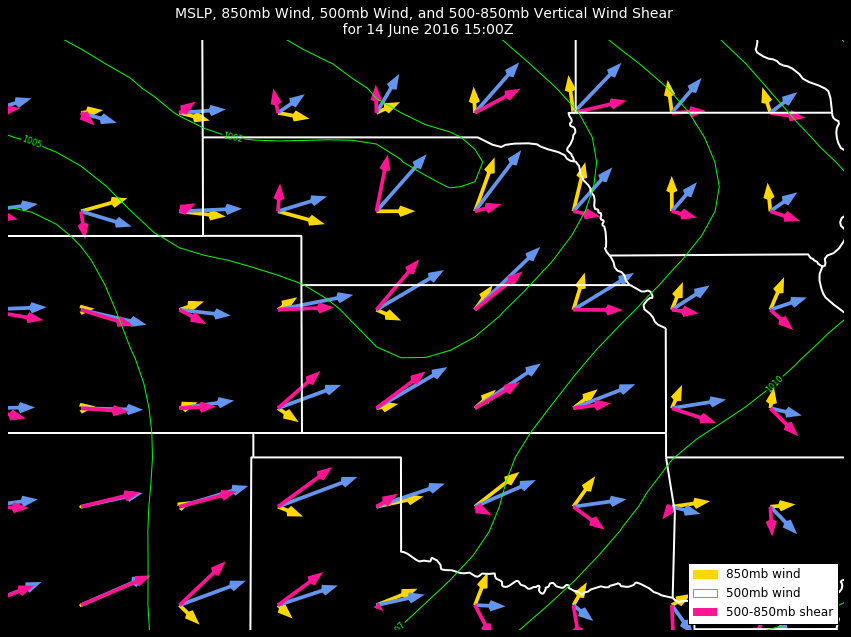

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create new figure
fig = plt.figure(figsize=(15,12), facecolor='black')

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-108., -91., 33., 45.])
ax.background_patch.set_fill(False)

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='white', linewidth=2)

# Contour the MSLP
c = ax.contour(lon_2d, lat_2d, mslp, colors='lime', linewidth=6)
ax.clabel(c, fontsize=8, inline=1, inline_spacing=2, fmt='%i')

# Plot 850-hPa wind vectors
vectors850 = ax.quiver(lon_2d[1::4,1::4], lat_2d[1::4,1::4], u_wind850[1::4,1::4], v_wind850[1::4,1::4], 
                       headlength=4, headwidth=3, angles='xy', scale_units='xy', scale=12, color='gold', label='850mb wind')
# Plot 500-hPa wind vectors
vectors500 = ax.quiver(lon_2d[1::4,1::4], lat_2d[1::4,1::4], u_wind500[1::4,1::4], v_wind500[1::4,1::4],
                       headlength=4, headwidth=3, angles='xy', scale_units='xy', scale=12, color='cornflowerblue', label='500mb wind')
# Plot 500-850 shear
shear = ax.quiver(lon_2d[1::4,1::4], lat_2d[1::4,1::4], u_wind500[1::4,1::4] - u_wind850[1::4,1::4], v_wind500[1::4,1::4] - v_wind850[1::4,1::4], 
                   headlength=4, headwidth=3, angles='xy', scale_units='xy', scale=12, color='deeppink', label='500-850mb shear')
# Add a legend
ax.legend(('850mb wind', '500mb wind', '500-850mb shear'), loc=4)

# Manually set colors for legend
legend = ax.get_legend()
legend.legendHandles[0].set_color('gold')
legend.legendHandles[1].set_color('cornflowerblue')
legend.legendHandles[2].set_color('deeppink')

# Add a title to the plot
plt.title('MSLP, 850mb Wind, 500mb Wind, and 500-850mb Vertical Wind Shear \n for {0:%d %B %Y %H:%MZ}'.format(time), color='white', size=14)

plt.show()